In [1]:
pip install livelossplot

In [2]:
pip install keras-tuner

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display, HTML
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import io
from keras.optimizers import Adam, SGD, RMSprop
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.regularizers import l1, l2
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import layers
from kerastuner import HyperModel
from keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense
from keras.layers import add
from keras.models import Model

Using TensorFlow backend


<ipython-input-3-8d9e957af074>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


## 1. Data preparation

### 1.1 Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Split the training data into training and validation sets

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_to_dataframe(data_batches):
    frames = []

    for batch in data_batches:
        data_dict = unpickle(batch)
        data = data_dict[b'data']
        labels = data_dict[b'labels']
        df = pd.DataFrame(data)
        df['label'] = labels
        frames.append(df)

    df_all = pd.concat(frames, ignore_index=True)
    return df_all

data_batches = ['/content/drive/My Drive/data_batch_1', '/content/drive/My Drive/data_batch_2', '/content/drive/My Drive/data_batch_3', '/content/drive/My Drive/data_batch_4', '/content/drive/My Drive/data_batch_5']
train_data = load_cifar10_to_dataframe(data_batches)
test_data = load_cifar10_to_dataframe(['/content/drive/My Drive/test_batch'])
print(train_data.head())

X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


     0    1    2    3    4    5    6    7    8    9  ...  3063  3064  3065  \
0   59   43   50   68   98  119  139  145  149  149  ...    58    65    59   
1  154  126  105  102  125  155  172  180  142  111  ...    42    67   101   
2  255  253  253  253  253  253  253  253  253  253  ...    83    80    69   
3   28   37   38   42   44   40   40   24   32   43  ...    39    59    42   
4  170  168  177  183  181  177  181  184  189  189  ...    88    85    82   

   3066  3067  3068  3069  3070  3071  label  
0    46    57   104   140    84    72      6  
1   122   133   136   139   142   144      9  
2    66    72    79    83    83    84      9  
3    44    48    38    28    37    46      4  
4    83    79    78    82    78    80      1  

[5 rows x 3073 columns]


In [6]:
print(y_train)

3106     6
46640    7
40276    8
33560    3
14770    2
        ..
17464    7
748      0
42709    1
19766    9
13471    3
Name: label, Length: 40000, dtype: int64


### 1.3 Data Exploration

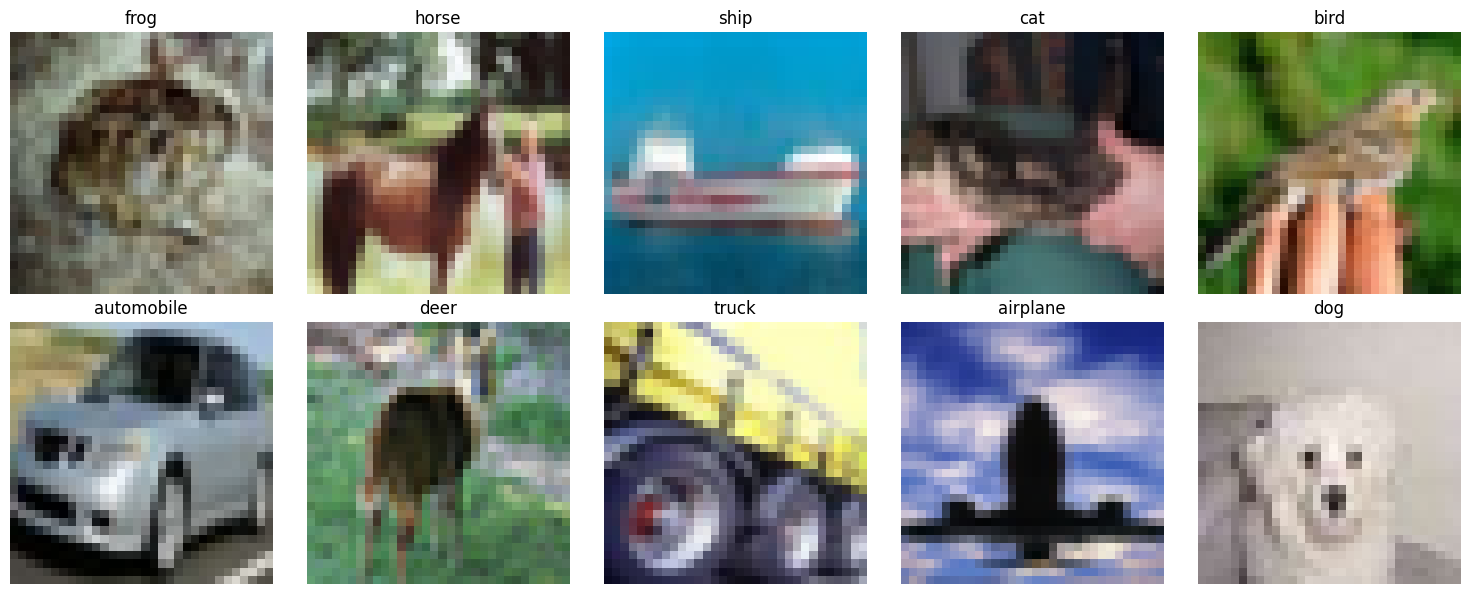

In [7]:
def load_label_names(meta_file):
    with open(meta_file, 'rb') as file:
        data = pickle.load(file, encoding='bytes')
        label_names = [name.decode('utf-8') for name in data[b'label_names']]
    return label_names

label_names = load_label_names('/content/drive/My Drive/batches.meta')

# 显示图像
def display_cifar_images(images, labels, label_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.ravel()):
        img = images.iloc[i].values.reshape(3, 32, 32).transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(label_names[labels.iloc[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 从训练数据中选择 10 个属于不同类别的图像
unique_labels = y_train.unique()
sample_images = []
sample_labels = []
for label in unique_labels:
    sample_image = X_train[y_train == label].iloc[0]
    sample_images.append(sample_image)
    sample_labels.append(label)
sample_images_df = pd.concat(sample_images, axis=1).transpose()
sample_labels_series = pd.Series(sample_labels)

# 展示图像
display_cifar_images(sample_images_df, sample_labels_series, label_names)

In [8]:
def display_class_distribution(data):
    # Labels mapping for CIFAR-10
    class_labels = {
        0: "Airplane", 1: "Automobile", 2: "Bird", 3: "Cat", 4: "Deer",
        5: "Dog", 6: "Frog", 7: "Horse", 8: "Ship", 9: "Truck"
    }

    # Calculate counts and percentages
    total_samples = len(data)
    counts = data["label"].value_counts()
    percentages = (counts / total_samples) * 100

    # Print the results
    print("Class Distribution:")
    [print(f"{class_labels[id]:<20s}:   {count} samples or {percentage:.2f}%")
     for id, count, percentage in zip(counts.index, counts.values, percentages.values)]

# Calling the function with train_data dataframe
combined_data = pd.concat([train_data, test_data], ignore_index=True)
display_class_distribution(combined_data)

Class Distribution:
Frog                :   6000 samples or 10.00%
Truck               :   6000 samples or 10.00%
Deer                :   6000 samples or 10.00%
Automobile          :   6000 samples or 10.00%
Bird                :   6000 samples or 10.00%
Horse               :   6000 samples or 10.00%
Ship                :   6000 samples or 10.00%
Cat                 :   6000 samples or 10.00%
Dog                 :   6000 samples or 10.00%
Airplane            :   6000 samples or 10.00%


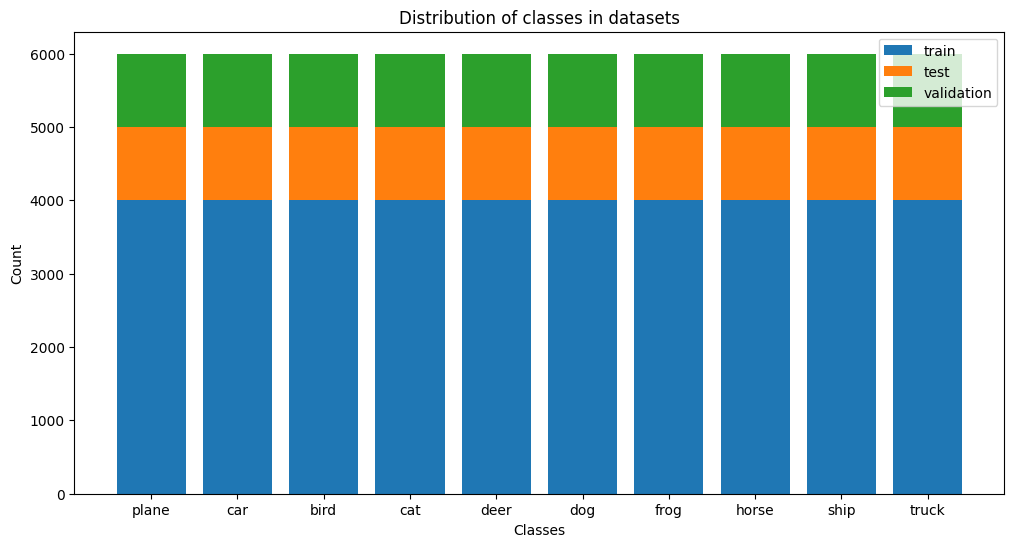

In [9]:
labels = {
    0: "plane", 1: "car", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

def plot_stacked_distribution(y_data_list, label_list):
    label_counts_list = [np.bincount(y_data) for y_data in y_data_list]
    bottom = np.zeros(len(label_counts_list[0]))
    for i, label_counts in enumerate(label_counts_list):
        plt.bar(labels.values(), label_counts, label=label_list[i], bottom=bottom)
        bottom += label_counts

fig = plt.figure(figsize=(12, 6))

# Plot stacked distributions for train, test, and validation sets on the same figure
plot_stacked_distribution([y_train, y_test, y_val], ['train', 'test', 'validation'])

plt.title('Distribution of classes in datasets')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.legend()
plt.show()

### 1.3 Data Preprocessing

In [10]:
def preprocess_data(data):
    # Reshape and normalize
    data = data.values.reshape(-1, 32, 32, 3).astype('float32') / 255.0
    # If you want to resize the image, use the following line. Otherwise, skip it.
    # data = tf.image.resize(data, [48, 48])
    return data

X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)
X_test = preprocess_data(X_test)

# Print the shape of each subset
print("Training set :", X_train.shape, y_train.shape)
print("Validation set :", X_val.shape, y_val.shape)
print("Test set :", X_test.shape, y_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)  # 10 classes for CIFAR-10
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

# datagen = ImageDataGenerator(
#     rotation_range=10,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,  # CIFAR-10 images can be flipped horizontally
#     vertical_flip=False)

# datagen.fit(X_train)

Training set : (40000, 32, 32, 3) (40000,)
Validation set : (10000, 32, 32, 3) (10000,)
Test set : (10000, 32, 32, 3) (10000,)


## 2. CNN


### 2.1 Define the Baseline Model

In [11]:
# Define the model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the model.
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0,
                          mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

callbacks = [earlystop, checkpoint]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, mode='auto',
                              patience=3, min_delta=0.0001, cooldown=2, min_lr=0.00001)
callbacks.append(reduce_lr)

# Summary of the model.
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

### 2.2 Baseline Model Training

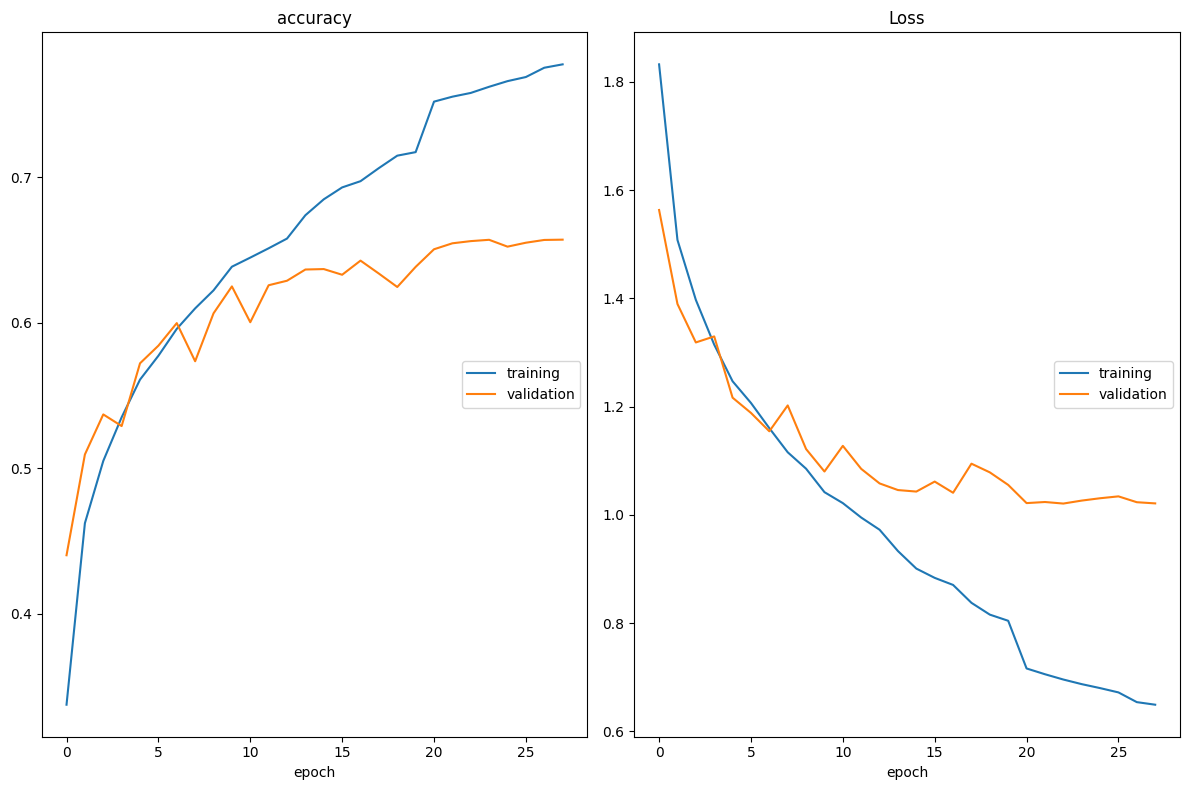

accuracy
	training         	 (min:    0.338, max:    0.777, cur:    0.777)
	validation       	 (min:    0.440, max:    0.657, cur:    0.657)
Loss
	training         	 (min:    0.649, max:    1.832, cur:    0.649)
	validation       	 (min:    1.021, max:    1.563, cur:    1.021)
Restoring model weights from the end of the best epoch: 23.
157/157 [==============================] - 1s 8ms/step - loss: 0.6490 - accuracy: 0.7774 - val_loss: 1.0210 - val_accuracy: 0.6570 - lr: 4.0000e-05
Epoch 28: early stopping


In [12]:
def prepare_callbacks():
    """Return a list of callbacks for model training."""
    # Add any other callbacks you need here
    return [
        PlotLossesCallback(),  # Live plotting
        checkpoint,
        earlystop,
        reduce_lr
    ]

def train_model(model, X_train, y_train, X_val, y_val):
    """Train the provided model using the given data."""
    history = model.fit(
        X_train,
        y_train,
        batch_size=256,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=prepare_callbacks(),
        verbose=1
    )
    return history

# Training the model
history_cnn = train_model(cnn_model, X_train, y_train, X_val, y_val)


### 2.3 Baseline Model Evaluation

In [13]:
cnn_score = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Baseline Validation loss:', cnn_score[0])
print('Baseline Validation accuracy:', cnn_score[1])

Baseline Validation loss: 1.0207356214523315
Baseline Validation accuracy: 0.656000018119812


### Comparing Different CNN Module

## 3.1 VGG 11

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l1_l2
from keras.optimizers import Adam

def create_vgg11_model(input_shape, num_classes):
    l1l2_regularizer = l1_l2(l1=0.0001, l2=0.0001)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1l2_regularizer, input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1l2_regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1l2_regularizer))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1l2_regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l1l2_regularizer))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l1l2_regularizer))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l1l2_regularizer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

adam = Adam(learning_rate=0.001)
vgg11 = create_vgg11_model((32, 32, 3), 10)  # Change the input shape to CIFAR-10 dimensions
vgg11.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
vgg11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

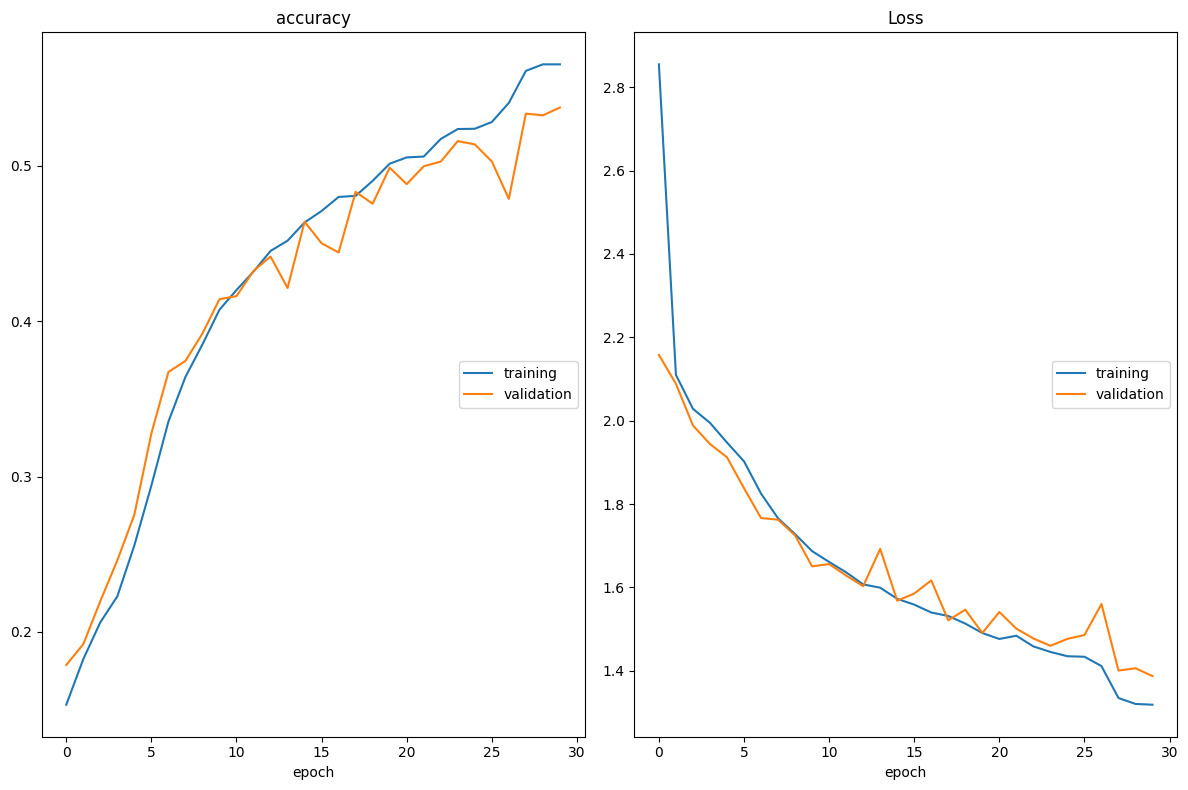

accuracy
	training         	 (min:    0.153, max:    0.565, cur:    0.565)
	validation       	 (min:    0.179, max:    0.538, cur:    0.538)
Loss
	training         	 (min:    1.319, max:    2.855, cur:    1.319)
	validation       	 (min:    1.387, max:    2.158, cur:    1.387)
157/157 [==============================] - 2s 12ms/step - loss: 1.3188 - accuracy: 0.5654 - val_loss: 1.3874 - val_accuracy: 0.5376 - lr: 2.0000e-04


In [15]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg11_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, epsilon=0.0001, cooldown=2, min_lr=0.0001)

def train_model(model, X_train, y_train, X_val, y_val):
    callbacks = [
        PlotLossesCallback(),
        checkpoint,
        earlystop,
        reduce_lr
    ]
    history = model.fit(
        X_train,
        y_train,
        batch_size=256,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
    return history

history_vgg11 = train_model(vgg11, X_train, y_train, X_val, y_val)

In [16]:
vgg11_score = vgg11.evaluate(X_val, y_val, verbose=0)
print('VGG11 Validation loss:', vgg11_score[0])
print('VGG11 Validation accuracy:', vgg11_score[1])

VGG11 Validation loss: 1.3873796463012695
VGG11 Validation accuracy: 0.5375999808311462


### 3.2 VGG16

In [17]:
def create_vgg16_model(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # We're omitting the deeper blocks (Block 4 & 5) to prevent the feature maps from getting too small.

    # FC layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

vgg16 = create_vgg16_model((32, 32, 3), 10)  # Change the input shape to CIFAR-10 dimensions
vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                 

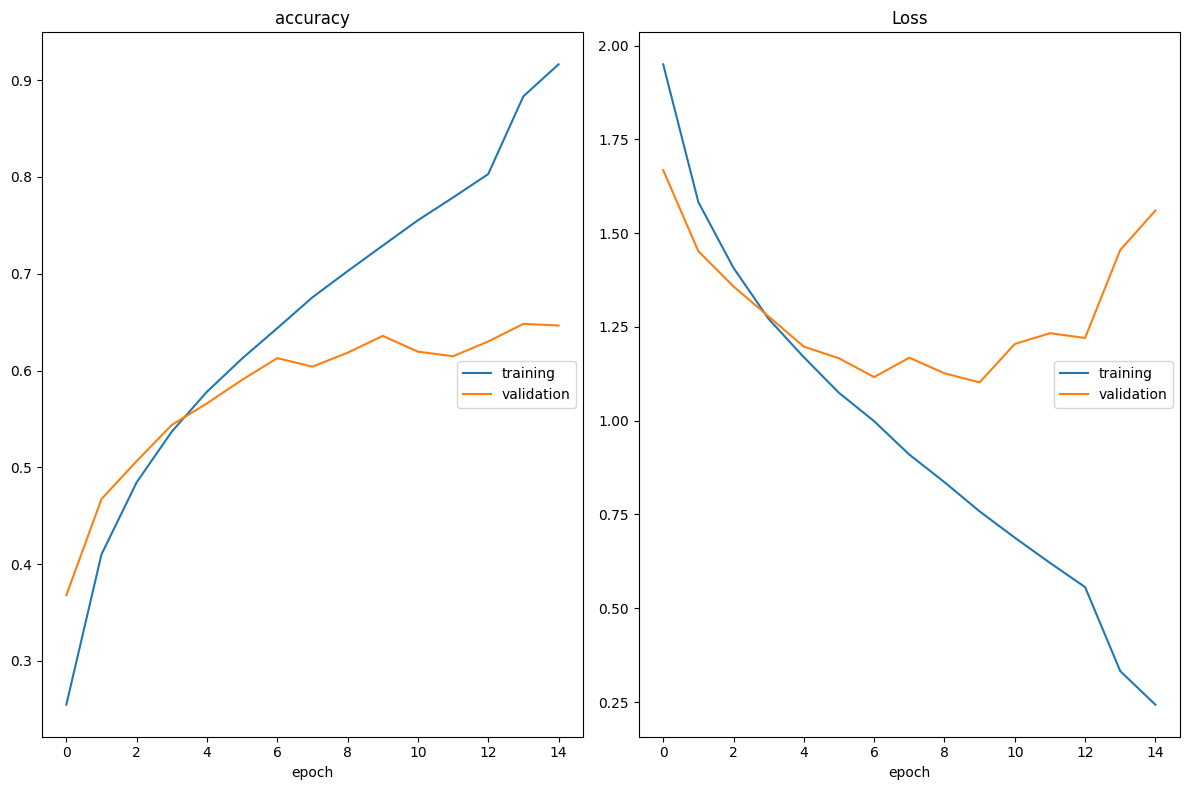

accuracy
	training         	 (min:    0.255, max:    0.916, cur:    0.916)
	validation       	 (min:    0.368, max:    0.648, cur:    0.646)
Loss
	training         	 (min:    0.243, max:    1.950, cur:    0.243)
	validation       	 (min:    1.102, max:    1.668, cur:    1.560)
Restoring model weights from the end of the best epoch: 10.
157/157 [==============================] - 5s 30ms/step - loss: 0.2428 - accuracy: 0.9164 - val_loss: 1.5601 - val_accuracy: 0.6465 - lr: 2.0000e-04
Epoch 15: early stopping


In [18]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, epsilon=0.0001, cooldown=2, min_lr=0.00001)

def train_model(model, X_train, y_train, X_val, y_val):
    callbacks = [
        PlotLossesCallback(),
        checkpoint,
        earlystop,
        reduce_lr
    ]
    history = model.fit(
        X_train,
        y_train,
        batch_size=256,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
    return history

history_vgg16 = train_model(vgg16, X_train, y_train, X_val, y_val)

In [19]:
vgg16_score = vgg16.evaluate(X_val, y_val, verbose=0)
print('VGG16 Validation loss:', vgg16_score[0])
print('VGG16 Validation accuracy:', vgg16_score[1])

VGG16 Validation loss: 1.1021209955215454
VGG16 Validation accuracy: 0.6358000040054321


## VGG16 pretrained

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

base_model.trainable = False

vgg16pretrained = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(10, activation='softmax')
])

vgg16pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


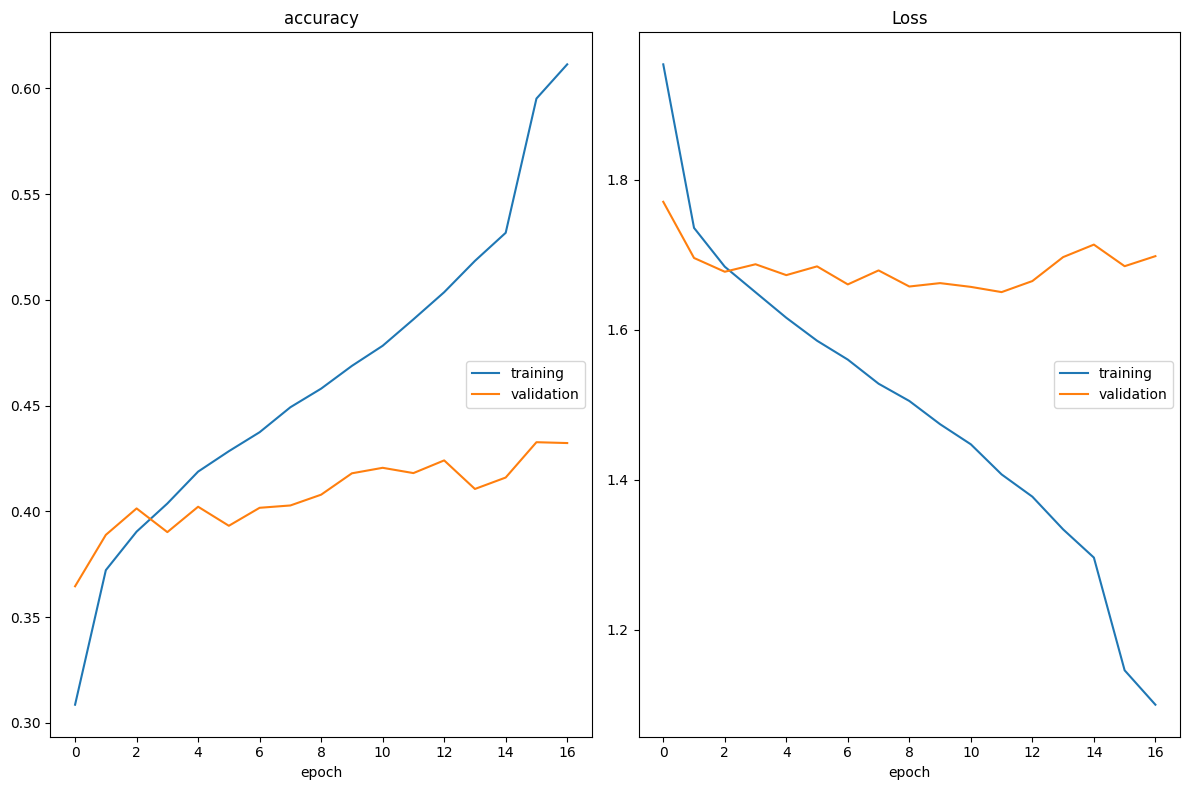

accuracy
	training         	 (min:    0.309, max:    0.611, cur:    0.611)
	validation       	 (min:    0.365, max:    0.433, cur:    0.432)
Loss
	training         	 (min:    1.100, max:    1.954, cur:    1.100)
	validation       	 (min:    1.650, max:    1.770, cur:    1.698)
Restoring model weights from the end of the best epoch: 12.
157/157 [==============================] - 4s 23ms/step - loss: 1.1000 - accuracy: 0.6113 - val_loss: 1.6980 - val_accuracy: 0.4323 - lr: 2.0000e-04
Epoch 17: early stopping


In [21]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16pretrained_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, epsilon=0.0001, cooldown=2, min_lr=0.0001)

def train_model(model, X_train, y_train, X_val, y_val):
    callbacks = [
        PlotLossesCallback(),
        checkpoint,
        earlystop,
        reduce_lr
    ]
    history = model.fit(
        X_train,
        y_train,
        batch_size=256,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
    return history

history_vgg16pretrained = train_model(vgg16pretrained, X_train, y_train, X_val, y_val)

In [25]:
vgg16pretrained_score = vgg16pretrained.evaluate(X_val, y_val, verbose=0)
print('vgg16pretrained Validation loss:', vgg16pretrained_score[0])
print('vgg16pretrained Validation accuracy:', vgg16pretrained_score[1])

vgg16pretrained Validation loss: 1.6500566005706787
vgg16pretrained Validation accuracy: 0.4180999994277954


## 4. Grid search for Best Module

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_network(optimizer='adam', dropout=0.2, lr=0.001, act_fn='relu'):
    net = models.Sequential([
        layers.Conv2D(32, kernel_size=3, activation=act_fn, input_shape=(32, 32, 3)),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, activation=act_fn),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation=act_fn),
        layers.Dropout(dropout),
        layers.Dense(10, activation='softmax')
    ])

    optimizers_dict = {
        'adam': optimizers.Adam(lr),
        'rmsprop': optimizers.RMSprop(lr),
        'sgd': optimizers.SGD(lr),
        'adagrad': optimizers.Adagrad(lr)
    }

    net.compile(optimizer=optimizers_dict.get(optimizer, 'adam'),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return net

# Setting up the hyperparameters grid
grid_params = {
    'optimizer': ['adam', 'adagrad'],
    'dropout': [0.1, 0.2],
    'lr': [0.0001,0.001],
    'act_fn': ['relu', 'tanh']
}

results_list, tried_params = [], []

# Grid search simulation
for opt in grid_params['optimizer']:
    for drop in grid_params['dropout']:
        for rate in grid_params['lr']:
            for act in grid_params['act_fn']:
                net = build_network(optimizer=opt, dropout=drop, lr=rate, act_fn=act)

                hist = net.fit(X_train, y_train,
                               validation_data=(X_val, y_val),
                               epochs=30, batch_size=256, verbose=0)

                best_val = max(hist.history['val_accuracy'])
                results_list.append(best_val)
                param_set = (opt, drop, rate, act)
                tried_params.append(param_set)

                print(f"Used parameters: {param_set}, Highest Val Accuracy: {best_val:.4f}")

highest_acc_index = np.argmax(results_list)
print("Optimal score: {:.4f} with parameters {}".format(results_list[highest_acc_index], tried_params[highest_acc_index]))

Used parameters: ('adam', 0.1, 0.0001, 'relu'), Highest Val Accuracy: 0.5738
Used parameters: ('adam', 0.1, 0.0001, 'tanh'), Highest Val Accuracy: 0.5969
Used parameters: ('adam', 0.1, 0.001, 'relu'), Highest Val Accuracy: 0.6481
Used parameters: ('adam', 0.1, 0.001, 'tanh'), Highest Val Accuracy: 0.6256
Used parameters: ('adam', 0.2, 0.0001, 'relu'), Highest Val Accuracy: 0.5730
Used parameters: ('adam', 0.2, 0.0001, 'tanh'), Highest Val Accuracy: 0.5857
Used parameters: ('adam', 0.2, 0.001, 'relu'), Highest Val Accuracy: 0.6488
Used parameters: ('adam', 0.2, 0.001, 'tanh'), Highest Val Accuracy: 0.6153
Used parameters: ('adagrad', 0.1, 0.0001, 'relu'), Highest Val Accuracy: 0.1992
Used parameters: ('adagrad', 0.1, 0.0001, 'tanh'), Highest Val Accuracy: 0.2562
Used parameters: ('adagrad', 0.1, 0.001, 'relu'), Highest Val Accuracy: 0.3706
Used parameters: ('adagrad', 0.1, 0.001, 'tanh'), Highest Val Accuracy: 0.4096
Used parameters: ('adagrad', 0.2, 0.0001, 'relu'), Highest Val Accurac

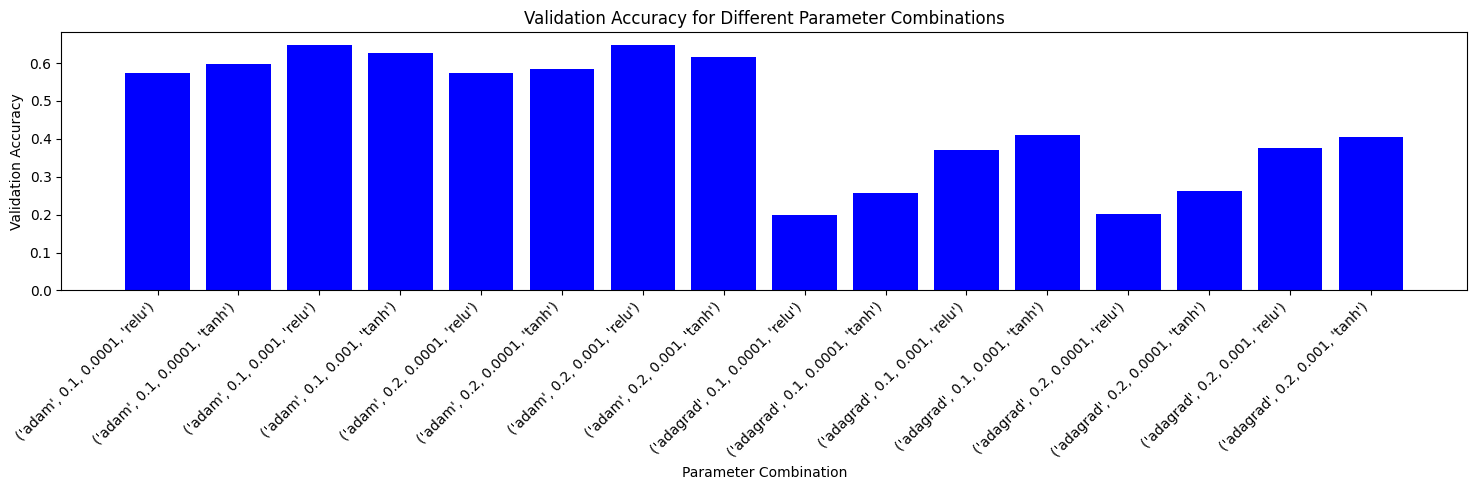

In [23]:
def plot_results(tried_params, results_list):
    # Convert parameter combinations to string for x-axis labels
    labels = [str(p) for p in tried_params]

    plt.figure(figsize=(15, 5))
    plt.bar(labels, results_list, color='blue')
    plt.xlabel('Parameter Combination')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy for Different Parameter Combinations')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the figure
    plt.show()

# Call the plotting function
plot_results(tried_params, results_list)